# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
from urllib.request import urlopen
import json

response = urlopen('https://api.openf1.org/v1/car_data?driver_number=55&session_key=9159&speed>=315')
data = json.loads(response.read().decode('utf-8'))
print(data)


[{'driver_number': 55, 'rpm': 11141, 'speed': 315, 'n_gear': 8, 'throttle': 99, 'brake': 0, 'drs': 12, 'date': '2023-09-15T13:08:19.923000+00:00', 'session_key': 9159, 'meeting_key': 1219}, {'driver_number': 55, 'rpm': 11023, 'speed': 315, 'n_gear': 8, 'throttle': 57, 'brake': 100, 'drs': 8, 'date': '2023-09-15T13:35:41.808000+00:00', 'session_key': 9159, 'meeting_key': 1219}]


In [2]:
from urllib.request import urlopen
import json
import pandas as pd

response = urlopen('https://api.openf1.org/v1/location?session_key=9161&driver_number=55&date>2023-09-16T13:17:39.916&date<2023-09-16T13:17:40.516')
data = json.loads(response.read().decode('utf-8'))
print(data)

df_laps = pd.DataFrame(data)
print(df_laps.head())

[{'x': 1006, 'y': -10, 'z': 188, 'driver_number': 55, 'date': '2023-09-16T13:17:40.332000+00:00', 'session_key': 9161, 'meeting_key': 1219}]
      x   y    z  driver_number                              date  \
0  1006 -10  188             55  2023-09-16T13:17:40.332000+00:00   

   session_key  meeting_key  
0         9161         1219  


In [62]:
from urllib.request import urlopen
import json

response = urlopen('https://api.openf1.org/v1/laps?session_key=9161&driver_number=16&lap_number=2')
data = json.loads(response.read().decode('utf-8'))
print(data)

# If you want, you can import the results in a DataFrame (you need to install the `pandas` package first)
# import pandas as pd
# df = pd.DataFrame(data)

[{'meeting_key': 1219, 'session_key': 9161, 'driver_number': 16, 'i1_speed': 311, 'i2_speed': 280, 'st_speed': 301, 'date_start': '2023-09-16T13:03:23.275000+00:00', 'lap_duration': 92.523, 'is_pit_out_lap': False, 'duration_sector_1': 27.262, 'duration_sector_2': 39.04, 'duration_sector_3': 26.221, 'segments_sector_1': [2049, 2049, 2049, 2049, 2049, 2051, 2051, 2051], 'segments_sector_2': [2049, 2049, 2049, 2051, 2049, 2049, 2049, 2049], 'segments_sector_3': [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048], 'lap_number': 2}]


# Based on the data, we can create a heat map of the braking points of Carlos Sainz
- We will use the `matplotlib` package to create the heat map
- We will use the `numpy` package to manipulate the data
- We will use the `pandas` package to import the data
- We will need a full lap to have the time of each braking point (lap_time)
- We will need the location of each braking point (location_x, location_y, location_z)
- We will need the speed of each braking point (speed)
- Lets begin

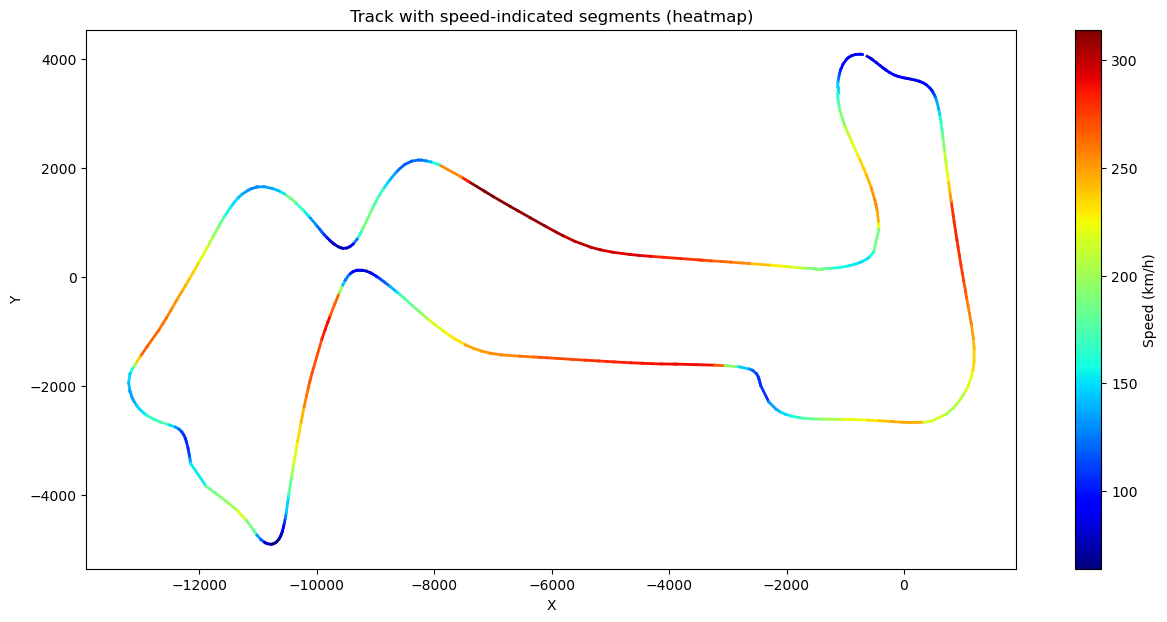

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json
from matplotlib import colormaps

# Base URL for location data
base_url = 'https://api.openf1.org/v1/location?session_key=9161&driver_number=55&date>'

# Time intervals
start_time = '2023-09-16T13:03:23.275'
mid_time1 = '2023-09-16T13:04:00.000'
mid_time2 = '2023-09-16T13:04:30.000'
end_time = '2023-09-16T13:04:59.319'

# Fetch location data in 3 parts
url1 = f'{base_url}{start_time}&date<{mid_time1}'
url2 = f'{base_url}{mid_time1}&date<{mid_time2}'
url3 = f'{base_url}{mid_time2}&date<{end_time}'
response1 = urlopen(url1)
response2 = urlopen(url2)
response3 = urlopen(url3)
data1 = json.loads(response1.read().decode('utf-8'))
data2 = json.loads(response2.read().decode('utf-8'))
data3 = json.loads(response3.read().decode('utf-8'))

# Combine location data
data_combined = data1 + data2 + data3
df_location = pd.DataFrame(data_combined)

# Fetch car data for speed
response = urlopen('https://api.openf1.org/v1/car_data?driver_number=55&session_key=9161&speed>=0')
data = json.loads(response.read().decode('utf-8'))
df_car_data = pd.DataFrame(data)

# Convert 'date' columns to datetime, handling mixed formats
df_location['date'] = pd.to_datetime(df_location['date'], format='mixed')
df_car_data['date'] = pd.to_datetime(df_car_data['date'], format='mixed')

# Merge the location data with car data on 'date' or 'timestamp'
df_merged = pd.merge_asof(df_location.sort_values('date'), df_car_data.sort_values('date'), on='date', direction='nearest')

# Normalize speed for color mapping (min speed = 0, max speed = 315 for F1 cars)
norm = plt.Normalize(vmin=df_merged['speed'].min(), vmax=df_merged['speed'].max())

# Use the new method to get the colormap
cmap = colormaps.get_cmap('jet')

# Plot with line segments colored by speed
fig, ax = plt.subplots(figsize=(15, 7))

for i in range(len(df_merged) - 1):
    x_values = [df_merged.iloc[i]['x'], df_merged.iloc[i + 1]['x']]
    y_values = [df_merged.iloc[i]['y'], df_merged.iloc[i + 1]['y']]

    # Get the color based on the speed at this segment
    color = cmap(norm(df_merged.iloc[i]['speed']))

    # Plot the segment with the corresponding color
    ax.plot(x_values, y_values, color=color, linewidth=2)

# Create a color bar to indicate speed
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for color bar
fig.colorbar(sm, ax=ax, label="Speed (km/h)")

ax.set_title('Track with speed-indicated segments (heatmap)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

£# *Version 1 of the heat map with speed-indicated segments on 1 lap of Carlos Sainz*

# Version 2 of the heat map with speed-indicated segments on 1 you can pick lap of any driver with his number

Lap start: 2023-07-30 13:07:33.642000+00:00, Lap end (+3 sec): 2023-07-30 13:09:28.934000+00:00


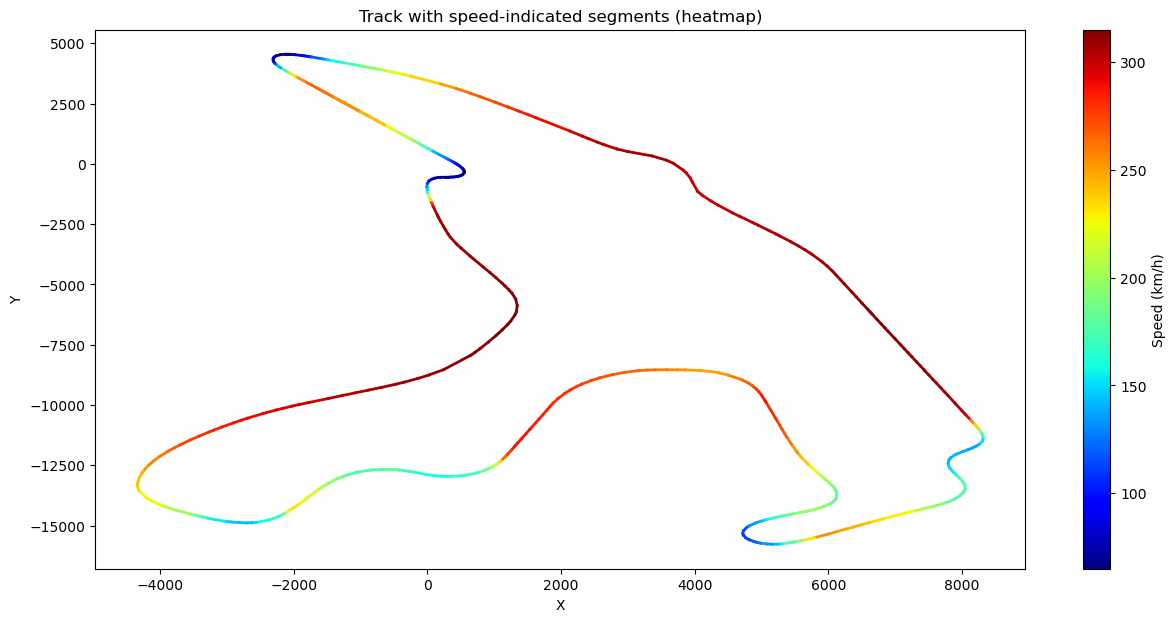

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json
from matplotlib import colormaps
from datetime import timedelta

# Fetch session data for Spa Francorchamps 2023
response = urlopen('https://api.openf1.org/v1/sessions?country_name=Belgium&session_name=Race&year=2023')
session_data = json.loads(response.read().decode('utf-8'))

# Check if session data is not empty
if not session_data:
    raise ValueError("No session data found for the specified criteria.")

# Ask which driver and lap number
driver_number = input('Enter driver number: ')
lap_number = input('Enter lap number: ')

# Fetch lap data for the specific driver and lap
response_lap = urlopen(f'https://api.openf1.org/v1/laps?session_key={session_data[0]["session_key"]}&driver_number={driver_number}&lap_number={lap_number}')
lap_data = json.loads(response_lap.read().decode('utf-8'))

# Ensure lap_data is a list
if isinstance(lap_data, list):
    lap_data = lap_data[0]  # Access the first element if it's a list

# Extract date_start and calculate date_end (date_start + lap_duration + 3 seconds)
date_start = pd.to_datetime(lap_data['date_start'])
lap_duration = timedelta(seconds=lap_data['lap_duration'])
date_end = date_start + lap_duration + timedelta(seconds=3)

print(f"Lap start: {date_start}, Lap end (+3 sec): {date_end}")

# Fetch location data for the specific lap using the time range
# Encode the dates to avoid control characters in the URL
date_start_str = date_start.isoformat()
date_end_str = date_end.isoformat()
response_location = urlopen(f'https://api.openf1.org/v1/location?session_key={session_data[0]["session_key"]}&driver_number={driver_number}&date>{date_start_str}&date<{date_end_str}')
location_data = json.loads(response_location.read().decode('utf-8'))

# Check if location data is not empty
if not location_data:
    raise ValueError("No location data found for the specified driver and lap.")

df_location = pd.DataFrame(location_data)

# Fetch car data for speed
response_car_data = urlopen(f'https://api.openf1.org/v1/car_data?driver_number={driver_number}&session_key={session_data[0]["session_key"]}&speed>=0')
car_data = json.loads(response_car_data.read().decode('utf-8'))

# Check if car data is not empty
if not car_data:
    raise ValueError("No car data found for the specified driver.")

df_car_data = pd.DataFrame(car_data)

# Convert 'date' columns to datetime, handling mixed formats
df_location['date'] = pd.to_datetime(df_location['date'], format='mixed')
df_car_data['date'] = pd.to_datetime(df_car_data['date'], format='mixed')

# Merge the location data with car data on 'date' or 'timestamp'
df_merged = pd.merge_asof(df_location.sort_values('date'), df_car_data.sort_values('date'), on='date', direction='nearest')

# Normalize speed for color mapping (min speed = 0, max speed = 315 for F1 cars)
norm = plt.Normalize(vmin=df_merged['speed'].min(), vmax=df_merged['speed'].max())

# Use the new method to get the colormap
cmap = colormaps.get_cmap('jet')

# Plot with line segments colored by speed
fig, ax = plt.subplots(figsize=(15, 7))

for i in range(len(df_merged) - 1):
    x_values = [df_merged.iloc[i]['x'], df_merged.iloc[i + 1]['x']]
    y_values = [df_merged.iloc[i]['y'], df_merged.iloc[i + 1]['y']]

    # Get the color based on the speed at this segment
    color = cmap(norm(df_merged.iloc[i]['speed']))

    # Plot the segment with the corresponding color
    ax.plot(x_values, y_values, color=color, linewidth=2)

# Create a color bar to indicate speed
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for color bar
fig.colorbar(sm, ax=ax, label="Speed (km/h)")

ax.set_title('Track with speed-indicated segments (heatmap)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

# Version 3: Choose the track and the session type

Lap start: 2023-05-26 15:05:36.689000+00:00, Lap end (+3 sec): 2023-05-26 15:06:54.725000+00:00


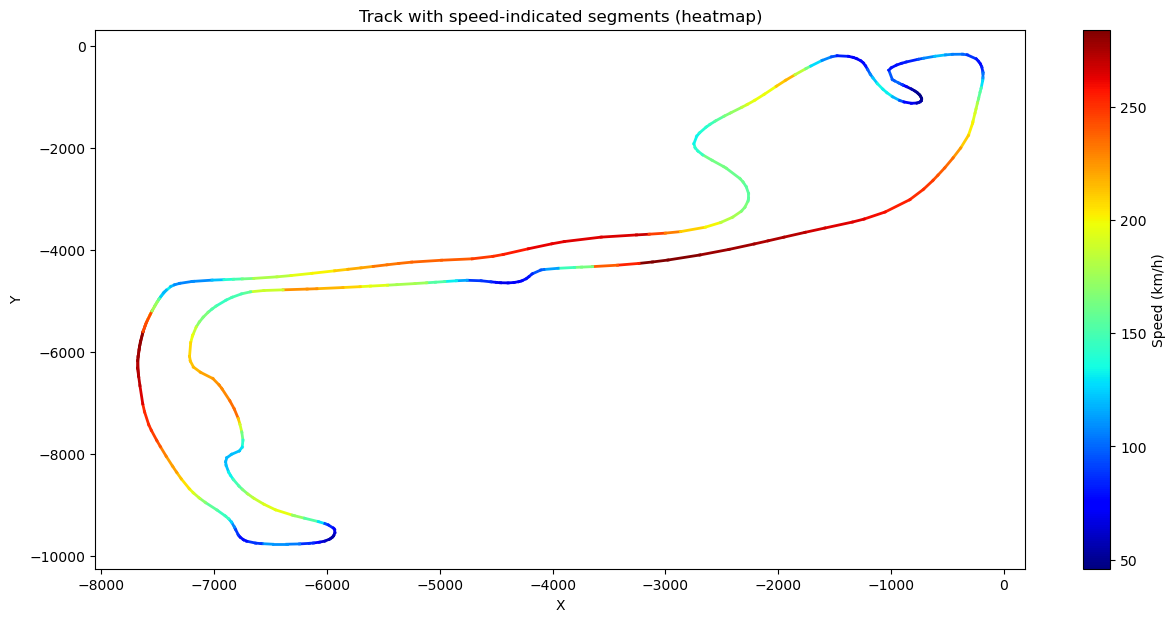

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.parse import urlencode
import json
from matplotlib import colormaps
from datetime import timedelta

# List of F1 countries and USA circuits
country_list = ['Bahrain', 'Saudi Arabia', 'Australia', 'Azerbaijan', 'United States', 'Monaco', 'Spain', 'Canada', 'Austria', 'Great Britain', 'Hungary', 'Belgium', 'Netherlands', 'Italy', 'Singapore', 'Japan', 'Qatar', 'Mexico', 'Brazil', 'Abu Dhabi']
usa_circuits = ['Miami', 'Austin', 'Las Vegas']

# Select the country
country = input('Enter the country: ')
while country not in country_list:
    country = input('Invalid country. Please enter a valid country: ')

# Handle the case of the United States to choose from available circuits
if country == 'United States':
    circuit = input('Enter the city (Miami, Austin, Las Vegas): ')
    while circuit not in usa_circuits:
        circuit = input('Invalid city. Please enter a valid city (Miami, Austin, Las Vegas): ')

# Ask for session type using a selection
session_type_list = ['Practice 1', 'Practice 2', 'Practice 3', 'Qualifying', 'Race', 'Sprint', 'Sprint Shootout']
session_type = input('Enter the session type: ')
while session_type not in session_type_list:
    session_type = input('Invalid session type. Please enter a valid session type: ')

# Prepare URL parameters
params = {
    'country_name': country,
    'session_name': session_type
}
if country == 'United States':
    params['location'] = circuit

# Encode URL parameters
url = f'https://api.openf1.org/v1/sessions?{urlencode(params)}'

response = urlopen(url)
session_data = json.loads(response.read().decode('utf-8'))

# Check if session data is not empty
if not session_data:
    raise ValueError("No session data found for the specified criteria.")

# Ask which driver and lap number
driver_number = input('Enter driver number: ')
lap_number = input('Enter lap number: ')

# Fetch lap data for the specific driver and lap
response_lap = urlopen(f'https://api.openf1.org/v1/laps?session_key={session_data[0]["session_key"]}&driver_number={driver_number}&lap_number={lap_number}')
lap_data = json.loads(response_lap.read().decode('utf-8'))

# Ensure lap_data is a list
if isinstance(lap_data, list) and lap_data:
    lap_data = lap_data[0]  # Access the first element if it's a list

# Extract date_start and calculate date_end (date_start + lap_duration + 3 seconds)
date_start = pd.to_datetime(lap_data['date_start'])
lap_duration = timedelta(seconds=lap_data['lap_duration'])
date_end = date_start + lap_duration + timedelta(seconds=3)

print(f"Lap start: {date_start}, Lap end (+3 sec): {date_end}")

# Fetch location data for the specific lap using the time range
# Encode the dates to avoid control characters in the URL
date_start_str = date_start.isoformat()
date_end_str = date_end.isoformat()
response_location = urlopen(f'https://api.openf1.org/v1/location?session_key={session_data[0]["session_key"]}&driver_number={driver_number}&date>{date_start_str}&date<{date_end_str}')
location_data = json.loads(response_location.read().decode('utf-8'))

# Check if location data is not empty
if not location_data:
    raise ValueError("No location data found for the specified driver and lap.")

df_location = pd.DataFrame(location_data)

# Fetch car data for speed
response_car_data = urlopen(f'https://api.openf1.org/v1/car_data?driver_number={driver_number}&session_key={session_data[0]["session_key"]}&speed>=0')
car_data = json.loads(response_car_data.read().decode('utf-8'))

# Check if car data is not empty
if not car_data:
    raise ValueError("No car data found for the specified driver.")

df_car_data = pd.DataFrame(car_data)

# Convert 'date' columns to datetime, handling mixed formats
df_location['date'] = pd.to_datetime(df_location['date'], format='mixed')
df_car_data['date'] = pd.to_datetime(df_car_data['date'], format='mixed')

# Merge the location data with car data on 'date' or 'timestamp'
df_merged = pd.merge_asof(df_location.sort_values('date'), df_car_data.sort_values('date'), on='date', direction='nearest')

# Normalize speed for color mapping (min speed = 0, max speed = 315 for F1 cars)
norm = plt.Normalize(vmin=df_merged['speed'].min(), vmax=df_merged['speed'].max())

# Use the new method to get the colormap
cmap = colormaps.get_cmap('jet')

# Plot with line segments colored by speed
fig, ax = plt.subplots(figsize=(15, 7))

for i in range(len(df_merged) - 1):
    x_values = [df_merged.iloc[i]['x'], df_merged.iloc[i + 1]['x']]
    y_values = [df_merged.iloc[i]['y'], df_merged.iloc[i + 1]['y']]

    # Get the color based on the speed at this segment
    color = cmap(norm(df_merged.iloc[i]['speed']))

    # Plot the segment with the corresponding color
    ax.plot(x_values, y_values, color=color, linewidth=2)

# Create a color bar to indicate speed
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for color bar
fig.colorbar(sm, ax=ax, label="Speed (km/h)")

ax.set_title('Track with speed-indicated segments (heatmap)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

# Version 4: Create an animation to draw the heatMap of the speed of a driver in a lap

Lap start: 2023-07-30 13:07:34.377000+00:00, Lap end (+3 sec): 2023-07-30 13:09:29.831000+00:00


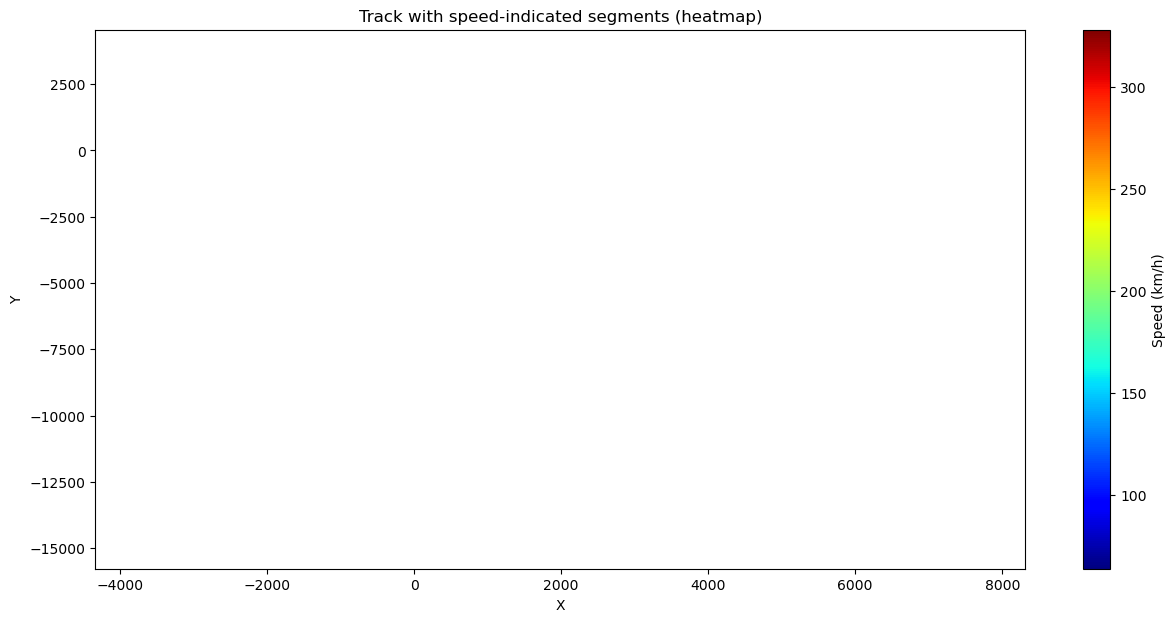

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.parse import urlencode
import json
from matplotlib import colormaps
from datetime import timedelta
from matplotlib.animation import FuncAnimation

# List of F1 countries and USA circuits
country_list = ['Bahrain', 'Saudi Arabia', 'Australia', 'Azerbaijan', 'United States', 'Monaco', 'Spain', 'Canada', 'Austria', 'Great Britain', 'Hungary', 'Belgium', 'Netherlands', 'Italy', 'Singapore', 'Japan', 'Qatar', 'Mexico', 'Brazil', 'Abu Dhabi']
usa_circuits = ['Miami', 'Austin', 'Las Vegas']

# Select the country
country = input('Enter the country: ')
while country not in country_list:
    country = input('Invalid country. Please enter a valid country: ')

# Handle the case of the United States to choose from available circuits
if country == 'United States':
    circuit = input('Enter the city (Miami, Austin, Las Vegas): ')
    while circuit not in usa_circuits:
        circuit = input('Invalid city. Please enter a valid city (Miami, Austin, Las Vegas): ')

# Ask for session type using a selection
session_type_list = ['Practice 1', 'Practice 2', 'Practice 3', 'Qualifying', 'Race', 'Sprint', 'Sprint Shootout']
session_type = input('Enter the session type: ')
while session_type not in session_type_list:
    session_type = input('Invalid session type. Please enter a valid session type: ')

# Prepare URL parameters
params = {
    'country_name': country,
    'session_name': session_type
}
if country == 'United States':
    params['location'] = circuit

# Encode URL parameters
url = f'https://api.openf1.org/v1/sessions?{urlencode(params)}'

response = urlopen(url)
session_data = json.loads(response.read().decode('utf-8'))

# Check if session data is not empty
if not session_data:
    raise ValueError("No session data found for the specified criteria.")

# Ask which driver and lap number
driver_number = input('Enter driver number: ')
lap_number = input('Enter lap number: ')

# Fetch lap data for the specific driver and lap
response_lap = urlopen(f'https://api.openf1.org/v1/laps?session_key={session_data[0]["session_key"]}&driver_number={driver_number}&lap_number={lap_number}')
lap_data = json.loads(response_lap.read().decode('utf-8'))

# Ensure lap_data is a list
if isinstance(lap_data, list) and lap_data:
    lap_data = lap_data[0]  # Access the first element if it's a list
else:
    raise ValueError("Invalid lap data format.")

# Extract date_start and calculate date_end (date_start + lap_duration + 3 seconds)
date_start = pd.to_datetime(lap_data['date_start'])
lap_duration = timedelta(seconds=lap_data['lap_duration'])
date_end = date_start + lap_duration + timedelta(seconds=3)

print(f"Lap start: {date_start}, Lap end (+3 sec): {date_end}")

# Fetch location data for the specific lap using the time range
# Encode the dates to avoid control characters in the URL
date_start_str = date_start.isoformat()
date_end_str = date_end.isoformat()
params_location = {
    'session_key': session_data[0]["session_key"],
    'driver_number': driver_number,
    'date>': date_start_str,
    'date<': date_end_str
}
url_location = f'https://api.openf1.org/v1/location?{urlencode(params_location)}'
response_location = urlopen(url_location)
location_data = json.loads(response_location.read().decode('utf-8'))

# Check if location data is not empty
if not location_data:
    raise ValueError("No location data found for the specified driver and lap.")

df_location = pd.DataFrame(location_data)

# Fetch car data for speed
response_car_data = urlopen(f'https://api.openf1.org/v1/car_data?driver_number={driver_number}&session_key={session_data[0]["session_key"]}&speed>=0')
car_data = json.loads(response_car_data.read().decode('utf-8'))

# Check if car data is not empty
if not car_data:
    raise ValueError("No car data found for the specified driver.")

df_car_data = pd.DataFrame(car_data)

# Convert 'date' columns to datetime, handling mixed formats
df_location['date'] = pd.to_datetime(df_location['date'], format='mixed')
df_car_data['date'] = pd.to_datetime(df_car_data['date'], format='mixed')

# Merge the location data with car data on 'date' or 'timestamp'
df_merged = pd.merge_asof(df_location.sort_values('date'), df_car_data.sort_values('date'), on='date', direction='nearest')

# Calculate 'distance' if missing
if 'distance' not in df_merged.columns:
    df_merged['distance'] = np.sqrt((df_merged['x'].diff()**2 + df_merged['y'].diff()**2).cumsum())
    df_merged['distance'] = df_merged['distance'].fillna(0)

# Normalize speed for color mapping (min speed = 0, max speed = 315 for F1 cars)
norm = plt.Normalize(vmin=df_merged['speed'].min(), vmax=df_merged['speed'].max())

# Use the new method to get the colormap
cmap = colormaps.get_cmap('jet')

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 7))

# Set up the plot limits
ax.set_xlim(df_merged['x'].min(), df_merged['x'].max())
ax.set_ylim(df_merged['y'].min(), df_merged['y'].max())

# Create a color bar to indicate speed
norm = plt.Normalize(vmin=df_merged['speed'].min(), vmax=df_merged['speed'].max())
cmap = colormaps.get_cmap('jet')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Speed (km/h)")

ax.set_title('Track with speed-indicated segments (heatmap)')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Initialize the list to store the line segments
lines = []

# Update function for animation
def update(frame):
    if frame < len(df_merged) - 1:
        # Extract the current and next coordinates
        x_values = [df_merged.iloc[frame]['x'], df_merged.iloc[frame + 1]['x']]
        y_values = [df_merged.iloc[frame]['y'], df_merged.iloc[frame + 1]['y']]

        # Get the color based on the speed at this frame
        color = cmap(norm(df_merged.iloc[frame]['speed']))

        # Plot the current segment
        line, = ax.plot(x_values, y_values, color=color, lw=2)
        lines.append(line)  # Store the line to keep it displayed
    return lines

# Create the animation and store it in a variable
anim = FuncAnimation(fig, update, frames=len(df_merged)-1, blit=False, interval=30)

# Show the plot
plt.show()